In [1]:
'''
Below is a standalone Jupyter Notebook code that will:

1.  **Analyze your training data (RAVDESS, CREMA-D):**
      * Extracts emotion labels.
      * Calculates audio file lengths.
      * Calculates Root Mean Square (RMS) as a proxy for audio volume/energy.
2.  **Provide a framework to analyze your "inference" data:**
      * **Crucially, you'll need to provide a path to a directory containing audio files that you've collected as a representative sample of your real-time inference environment.**
      * Performs the same length and RMS analysis.
3.  **Visualize and compare:**
      * Label distributions (training only, as inference won't have ground truth labels).
      * Audio length distributions (training vs. inference).
      * RMS distributions (training vs. inference).

'''

import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # For nice progress bars in Jupyter


In [7]:

# --- Configuration ---
# IMPORTANT: SET THESE PATHS
RAVDESS_PATH = '../data/ravedess/data' # e.g., 'C:/Users/paude/Datasets/RAVDESS'
CREMAD_PATH = '../data/CREMA-D/data' # e.g., 'C:/Users/paude/Datasets/CREMA-D'
# IMPORTANT: CREATE AND SET THIS PATH FOR YOUR INFERENCE DATA SAMPLE
# This should be a folder containing WAV files representative of your real-time audio.
INFERENCE_DATA_SAMPLE_PATH = '../test_data/' 

TARGET_SAMPLE_RATE = 16000 # Your model's target sample rate
# ---------------------

# --- Helper Functions for Data Extraction ---

# RAVDESS Emotion Mapping
# Filename format: 03-01-01-01-01-01-01.wav
# Emotion (third digit): 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised
RAVDESS_EMOTION_MAP = {
    '01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad',
    '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'
}

def extract_ravdess_info(file_path):
    basename = os.path.basename(file_path)
    parts = basename.split('-')
    if len(parts) >= 3:
        emotion_code = parts[2]
        return RAVDESS_EMOTION_MAP.get(emotion_code, 'Unknown')
    return 'Unknown'

# CREMA-D Emotion Mapping
# Filename format: 1001_TIE_ANG_XX.wav (Emotion is 3rd part: ANG, DIS, FEA, HAP, NEU, SAD)
CREMAD_EMOTION_MAP = {
    'ANG': 'Angry', 'DIS': 'Disgust', 'FEA': 'Fearful',
    'HAP': 'Happy', 'NEU': 'Neutral', 'SAD': 'Sad'
}

def extract_cremad_info(file_path):
    basename = os.path.basename(file_path)
    parts = basename.split('_')
    if len(parts) >= 3:
        emotion_code = parts[2]
        return CREMAD_EMOTION_MAP.get(emotion_code, 'Unknown')
    return 'Unknown'

def load_audio_info(data_path, dataset_type):
    """
    Loads audio file paths, extracts labels, and computes length and RMS.
    Args:
        data_path (str): Root directory of the dataset.
        dataset_type (str): 'ravdess', 'cremad', or 'inference'.
    Returns:
        pd.DataFrame: DataFrame with 'path', 'label' (for training), 'length_sec', 'rms'.
    """
    audio_info = []
    
    if not os.path.exists(data_path):
        print(f"Warning: Data path '{data_path}' not found. Skipping {dataset_type} analysis.")
        return pd.DataFrame()

    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                label = 'N/A' # Default for inference data
                if dataset_type == 'ravdess':
                    label = extract_ravdess_info(file_path)
                elif dataset_type == 'cremad':
                    label = extract_cremad_info(file_path)
                
                try:
                    # Load only metadata to get sample rate and num frames efficiently
                    info = torchaudio.info(file_path)
                    sample_rate = info.sample_rate
                    num_frames = info.num_frames
                    length_sec = num_frames / sample_rate

                    # Load a small chunk or the whole waveform to calculate RMS
                    # For performance, could also just load info and then compute RMS on demand
                    # For simplicity, let's load it here (it's small files anyway)
                    waveform, sr = torchaudio.load(file_path, normalize=True) # Normalize to -1 to 1
                    
                    # Resample if needed to match target SR before RMS calculation for consistency
                    if sr != TARGET_SAMPLE_RATE:
                        resampler = torchaudio.transforms.Resample(sr, TARGET_SAMPLE_RATE)
                        waveform = resampler(waveform)

                    rms = torch.sqrt(torch.mean(waveform**2)).item()

                    audio_info.append({
                        'path': file_path,
                        'label': label,
                        'length_sec': length_sec,
                        'rms': rms,
                        'dataset': dataset_type
                    })
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue
    return pd.DataFrame(audio_info)


--- Analyzing Training Data ---
Found 7442 training samples.

--- Analyzing Inference Data Sample ---
Found 4 inference samples. (Ensure this is representative!)



C:\Users\paude\AppData\Local\Temp\ipykernel_48500\3680236616.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=training_df, x='label', palette='viridis', order=training_df['label'].value_counts().index)


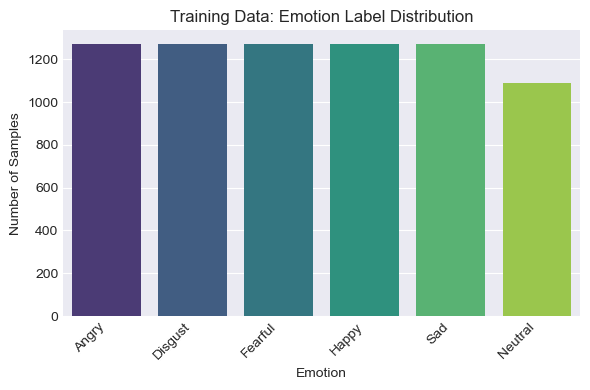

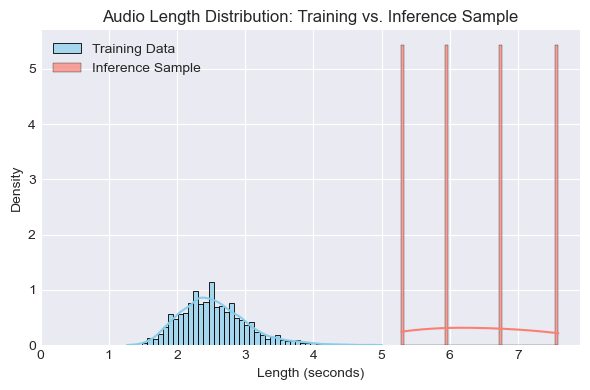

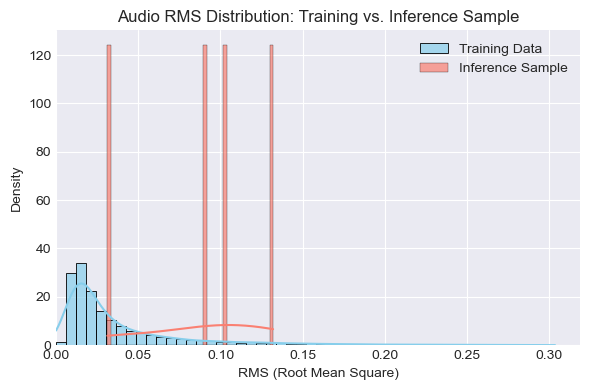

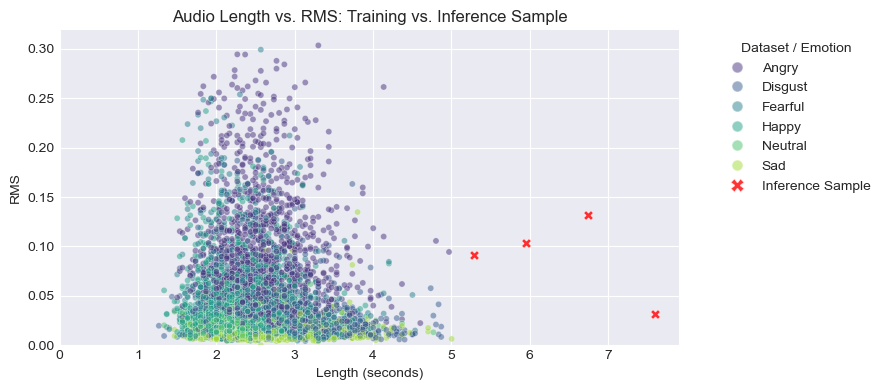


--- Summary Statistics for Training Data ---
        length_sec          rms
count  7442.000000  7442.000000
mean      2.542884     0.039115
std       0.505979     0.042370
min       1.267937     0.000000
25%       2.202187     0.013707
50%       2.502500     0.022654
75%       2.836187     0.046454
max       5.005000     0.303515

--- Summary Statistics for Inference Data Sample ---
       length_sec       rms
count    4.000000  4.000000
mean     6.394667  0.089532
std      0.995816  0.042446
min      5.290667  0.031173
25%      5.786667  0.076477
50%      6.346667  0.097479
75%      6.954667  0.110535
max      7.594667  0.131997

--- Interpretation Guidelines ---
1. Label Distribution (Training): Check for class imbalance. Highly imbalanced classes might need weighting during training.
2. Length Distribution: Compare the shapes and ranges. If inference data is significantly shorter/longer or has different peaks, your fixed `max_audio_len_seconds` (for training) needs to accommodate 

In [12]:

# --- Main Analysis ---

print("--- Analyzing Training Data ---")
ravdess_df = load_audio_info(RAVDESS_PATH, 'ravdess')
cremad_df = load_audio_info(CREMAD_PATH, 'cremad')
training_df = pd.concat([ravdess_df, cremad_df], ignore_index=True)
print(f"Found {len(training_df)} training samples.")

print("\n--- Analyzing Inference Data Sample ---")
inference_df = load_audio_info(INFERENCE_DATA_SAMPLE_PATH, 'inference')
print(f"Found {len(inference_df)} inference samples. (Ensure this is representative!)\n")

# --- Visualizations ---

plt.style.use('seaborn-v0_8-darkgrid')

# 1. Training Data Label Distribution
if not training_df.empty:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=training_df, x='label', palette='viridis', order=training_df['label'].value_counts().index)
    plt.title('Training Data: Emotion Label Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No training data to plot label distribution.")

# 2. Audio Length Distribution (Training vs. Inference)
plt.figure(figsize=(6, 4))
sns.histplot(data=training_df, x='length_sec', color='skyblue', label='Training Data', kde=True, stat='density', alpha=0.7, bins=50)
sns.histplot(data=inference_df, x='length_sec', color='salmon', label='Inference Sample', kde=True, stat='density', alpha=0.7, bins=50)
plt.title('Audio Length Distribution: Training vs. Inference Sample')
plt.xlabel('Length (seconds)')
plt.ylabel('Density')
plt.legend()
plt.xlim(left=0) # Ensure x-axis starts from 0
plt.tight_layout()
plt.show()

# 3. RMS (Volume/Energy) Distribution (Training vs. Inference)
plt.figure(figsize=(6, 4))
sns.histplot(data=training_df, x='rms', color='skyblue', label='Training Data', kde=True, stat='density', alpha=0.7, bins=50)
sns.histplot(data=inference_df, x='rms', color='salmon', label='Inference Sample', kde=True, stat='density', alpha=0.7, bins=50)
plt.title('Audio RMS Distribution: Training vs. Inference Sample')
plt.xlabel('RMS (Root Mean Square)')
plt.ylabel('Density')
plt.legend()
plt.xlim(left=0) # Ensure x-axis starts from 0
plt.tight_layout()
plt.show()

# 4. (Optional) Length vs. RMS (Training vs. Inference)
plt.figure(figsize=(9, 4))

# Plot Training Data: hue will automatically generate legend entries for emotions
if not training_df.empty:
    sns.scatterplot(data=training_df, x='length_sec', y='rms', hue='label', 
                    palette='viridis', s=20, alpha=0.5, 
                    # Remove the 'label' argument here to avoid conflict
                    # label='Training Data' # <-- This was causing the error
                   )

# Plot Inference Data: just plot without hue for labels, and manually add a legend entry
if not inference_df.empty:
    # Use a dummy variable for hue if you want it to appear in the legend automatically
    # Or plot without hue and use a custom legend handle
    
    # Easiest: Plot inference without 'hue' (since it has no labels) and add a custom legend entry.
    # The default legend from the first scatterplot (training data) will still be there.
    # We'll then add a manual entry for "Inference Sample".
    
    # Plot inference data directly
    sns.scatterplot(data=inference_df, x='length_sec', y='rms', 
                    color='red', marker='X', s=50, alpha=0.8,
                    # No 'hue' or 'label' argument here
                   )
    
# Manually create a legend entry for the inference data
# This part goes AFTER both scatterplot calls
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=emotion, 
                          markerfacecolor=sns.color_palette('viridis', n_colors=len(training_df['label'].unique()))[i], 
                          markersize=8, alpha=0.5) 
                   for i, emotion in enumerate(training_df['label'].unique())]

legend_elements.append(Line2D([0], [0], marker='X', color='w', label='Inference Sample', 
                              markerfacecolor='red', markersize=10, alpha=0.8))

plt.title('Audio Length vs. RMS: Training vs. Inference Sample')
plt.xlabel('Length (seconds)')
plt.ylabel('RMS')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend(handles=legend_elements, title='Dataset / Emotion', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
plt.tight_layout()
plt.show()

# --- Summary Statistics ---
print("\n--- Summary Statistics for Training Data ---")
print(training_df[['length_sec', 'rms']].describe())
print("\n--- Summary Statistics for Inference Data Sample ---")
print(inference_df[['length_sec', 'rms']].describe())

# --- Analysis Guidance ---
print("\n--- Interpretation Guidelines ---")
print("1. Label Distribution (Training): Check for class imbalance. Highly imbalanced classes might need weighting during training.")
print("2. Length Distribution: Compare the shapes and ranges. If inference data is significantly shorter/longer or has different peaks, your fixed `max_audio_len_seconds` (for training) needs to accommodate this, and augmentations (clipping/padding) become even more crucial.")
print("   - If training data is mostly ~3-4 seconds, and inference is often ~1-2 seconds, your model might struggle with very short clips, or with longer silences around short clips in a fixed window.")
print("3. RMS Distribution: Compare the shapes and ranges. A lower RMS for inference data could indicate quieter recordings, more background noise, or more silence. A higher RMS could mean louder speech or clipping.")
print("   - This is a key indicator of ambient noise level and recording quality mismatch.")
print("4. Length vs. RMS Scatter Plot: Look for patterns. E.g., are shorter clips in training systematically louder or quieter? Does inference data cluster differently?")
print("\n**Action:** Based on these plots, choose a `max_audio_len_seconds` for your training that makes sense. A good starting point is usually the 95th percentile of your training data length, or your real-time inference window size (e.g., 5 seconds), whichever is larger.")
